# <span style="color:blue">Explainable AI in Natural Language Processing - ANN Training Notebook</span>

## ANN Keras Implementation & Training



Author: Amir Mozahebi <br>
Thesis: Evaluating Sequence Learning Models for Identifying Hate Speech using Explainable AI

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
import keras_tuner
from keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import os, shutil
import gc

In [2]:
%store -r sequenceLength
%store -r vocabSize
%store -r paddedTrainSequences
%store -r trainLabels
%store -r paddedTestSequences
%store -r testLabels
%store -r tokenizer

In [3]:
print("Sequence Length: " + str(sequenceLength))
print("Vocab Size: " + str(vocabSize))
print(trainLabels[:5])

Sequence Length: 25
Vocab Size: 28829
23943    1
15123    1
4213     2
18820    1
6261     2
Name: label, dtype: int64


In [4]:
len(paddedTestSequences)

10796

In [5]:
trainLabels = tf.keras.utils.to_categorical(trainLabels, num_classes=3)
testLabels_backup = testLabels
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes=3)

In [6]:
trainLabels[0]

array([0., 1., 0.], dtype=float32)

In [7]:
#Define function to plot the history of the model training (accuracy + loss)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

In [8]:
def plotConfusionMatrix(cm):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(3,3)

    ax = sns.heatmap(cm, annot=labels, fmt="",cmap='Blues')

    ax.set_title('Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values \n');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])
    ax.yaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## ANN Model Tuning - Using Keras Tuner to optimize hyperparameters

In [23]:
# Callback to use garbage collector after each epoch to improve memory usage
class GCCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [24]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential()
        model.add(layers.Dense(units=hp.Int("units_hidden_1", min_value=32, max_value=512, step=16), input_dim=sequenceLength, activation=hp.Choice('activation1', ['relu', 'sigmoid', 'tanh'])))
        model.add(layers.Dense(units=hp.Int("units_hidden_2", min_value=32, max_value=512, step=16), activation=hp.Choice('activation2', ['relu', 'sigmoid', 'tanh'])))
        model.add(layers.Dense(3,activation="sigmoid"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
            loss='binary_crossentropy',
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [25]:
# Define model hyperparameters before tuning
def buildModel(hp):
    model = keras.models.Sequential()
    model.add(layers.Dense(units=hp.Int("units_hidden_1", min_value=32, max_value=512, step=16), input_dim=sequenceLength, activation=hp.Choice('activation1', ['relu', 'sigmoid', 'tanh'])))
    model.add(layers.Dense(units=hp.Int("units_hidden_2", min_value=32, max_value=512, step=16), activation=hp.Choice('activation2', ['relu', 'sigmoid', 'tanh'])))
    model.add(layers.Dense(3,activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
    return model
        

In [26]:
# Method to delete files in log directory
def cleanLogs(path):
    folder = path
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [27]:
def tuneModels(epoch_min, epoch_max, step, X_train, X_label, Y_train, Y_label, num_trials):
    
    tuners = []
    best_model_by_epoch = []
    counter=0
    
    for i in range(epoch_min, epoch_max, step):
        counter += 1
        logPath = "training_logs/ann_logs/tb_logs_ann_tuner_" + str(counter)
        cleanLogs(logPath)
        tuner = keras_tuner.BayesianOptimization(
        MyHyperModel(),
        objective='val_accuracy',
        max_trials=num_trials,
        overwrite = True,
        directory='../tuner_dir/ann_tuner_' + str(counter))
        buildModel(keras_tuner.HyperParameters())
        tuner.search(X_train, X_label, epochs=i, validation_data=(Y_train, Y_label),
        callbacks=[keras.callbacks.TensorBoard(logPath)])
        tuners.append(tuner)
        
    for tuner in tuners:
        model = tuner.get_best_models(num_models=1)
        best_model_by_epoch.append(model[0])
            
    return tuners, best_model_by_epoch

In [28]:
def tuneModelByEpoch(epochs, X_train, X_label, Y_train, Y_label, num_trials, logPathCounter):
     
    logPath = "training_logs/ann_logs/tb_logs_ann_tuner_" + str(logPathCounter)
    cleanLogs(logPath)
      
    tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=num_trials,
    overwrite = True,
    directory='../tuner_dir/ann/ann_tuner_' + str(logPathCounter))
    buildModel(keras_tuner.HyperParameters())
    
    tuner.search(X_train, X_label, epochs=epochs, validation_data=(paddedTestSequences, testLabels), verbose=0,
    callbacks=[GCCallback(),keras.callbacks.TensorBoard(logPath)])     
  
    best_model_by_epoch = tuner.get_best_models(num_models=1)[0]
           
    return tuner, best_model_by_epoch

In [29]:
#tuners, best_models = tuneModels(10, 51, 20, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5)

### Best model for 10 epochs of training

In [30]:
tuner_1, best_model_1 = tuneModelByEpoch(10, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 1)

Metal device set to: Apple M1 Pro


2023-01-13 11:03:24.795389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-13 11:03:24.795514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-13 11:03:24.964618: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-13 11:03:25.087653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:03:31.178002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:04:33.593326: I tensorflow/core/grappler/o

2023-01-13 11:06:04.468550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:06:11.061495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Oracle triggered exit


In [31]:
tuner_1.results_summary()

Results summary
Results in ../tuner_dir/ann/ann_tuner_1/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_hidden_1: 304
activation1: sigmoid
units_hidden_2: 224
activation2: tanh
lr: 0.0006574136998780315
batch_size: 64
Score: 0.43201184272766113
Trial summary
Hyperparameters:
units_hidden_1: 480
activation1: sigmoid
units_hidden_2: 416
activation2: relu
lr: 0.0007924893921348824
batch_size: 32
Score: 0.4271952509880066
Trial summary
Hyperparameters:
units_hidden_1: 336
activation1: tanh
units_hidden_2: 176
activation2: relu
lr: 0.0017314000248943061
batch_size: 128
Score: 0.4193219840526581
Trial summary
Hyperparameters:
units_hidden_1: 336
activation1: tanh
units_hidden_2: 144
activation2: tanh
lr: 0.002653730410809317
batch_size: 32
Score: 0.404964804649353
Trial summary
Hyperparameters:
units_hidden_1: 368
activation1: sigmoid
units_hidden_2: 48
activation2: relu
lr: 0.006697064920693329
batch_size: 64
Score

In [32]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 304)               7904      
                                                                 
 dense_1 (Dense)             (None, 224)               68320     
                                                                 
 dense_2 (Dense)             (None, 3)                 675       
                                                                 
Total params: 76,899
Trainable params: 76,899
Non-trainable params: 0
_________________________________________________________________


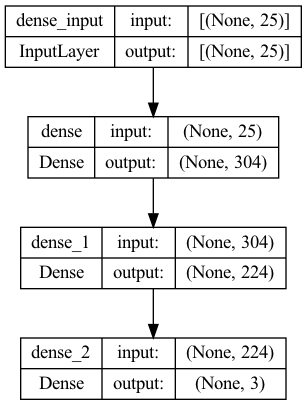

In [33]:
tf.keras.utils.plot_model(best_model_1, to_file='../plots/model_plots/ann/ann_model_1.png', show_shapes=True)

In [34]:
y_pred = best_model_1.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

105/338 [========>.....................] - ETA: 0s

2023-01-13 11:07:16.408900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 1s 1ms/step


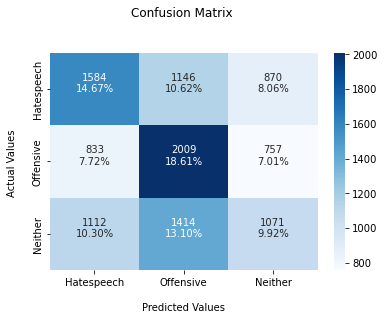

In [35]:
plotConfusionMatrix(cm)

In [36]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.45      0.44      0.44      3600
           1       0.44      0.56      0.49      3599
           2       0.40      0.30      0.34      3597

    accuracy                           0.43     10796
   macro avg       0.43      0.43      0.43     10796
weighted avg       0.43      0.43      0.43     10796



In [37]:
best_model_1.save('../models/ann_models/ann_model_1')

INFO:tensorflow:Assets written to: ../models/ann_models/ann_model_1/assets


### Best model for 30 epochs of training

In [38]:
tuner_2, best_model_2 = tuneModelByEpoch(30, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 2)

2023-01-13 11:07:17.504359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:07:23.614468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:10:42.347567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:10:44.026855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:11:36.202361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:11:37.882601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:12:29.141391: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Oracle triggered exit


In [39]:
tuner_2.results_summary()

Results summary
Results in ../tuner_dir/ann/ann_tuner_2/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_hidden_1: 192
activation1: sigmoid
units_hidden_2: 416
activation2: tanh
lr: 0.00047168627973271846
batch_size: 64
Score: 0.44090405106544495
Trial summary
Hyperparameters:
units_hidden_1: 128
activation1: sigmoid
units_hidden_2: 128
activation2: tanh
lr: 0.0001183672101403047
batch_size: 32
Score: 0.4321044683456421
Trial summary
Hyperparameters:
units_hidden_1: 160
activation1: relu
units_hidden_2: 240
activation2: sigmoid
lr: 0.003256343224504914
batch_size: 128
Score: 0.3963505029678345
Trial summary
Hyperparameters:
units_hidden_1: 32
activation1: relu
units_hidden_2: 80
activation2: sigmoid
lr: 0.004737198185425148
batch_size: 128
Score: 0.3939422070980072
Trial summary
Hyperparameters:
units_hidden_1: 176
activation1: relu
units_hidden_2: 400
activation2: relu
lr: 0.001256442713911361
batch_size: 64
S

In [40]:
best_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               4992      
                                                                 
 dense_1 (Dense)             (None, 416)               80288     
                                                                 
 dense_2 (Dense)             (None, 3)                 1251      
                                                                 
Total params: 86,531
Trainable params: 86,531
Non-trainable params: 0
_________________________________________________________________


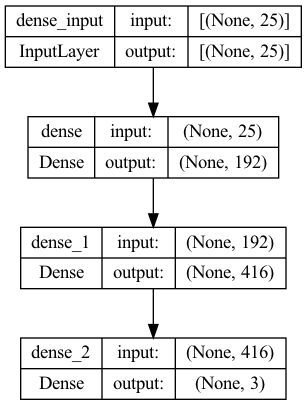

In [41]:
tf.keras.utils.plot_model(best_model_2, to_file='../plots/model_plots/ann_model_2.png', show_shapes=True)

In [42]:
y_pred = best_model_2.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

116/338 [=========>....................] - ETA: 0s

2023-01-13 11:15:58.586787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 0s 1ms/step


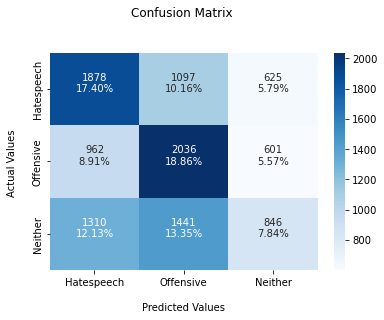

In [43]:
plotConfusionMatrix(cm)

In [44]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.45      0.52      0.48      3600
           1       0.45      0.57      0.50      3599
           2       0.41      0.24      0.30      3597

    accuracy                           0.44     10796
   macro avg       0.44      0.44      0.43     10796
weighted avg       0.44      0.44      0.43     10796



In [45]:
best_model_2.save('../models/ann_models/ann_model_2')

INFO:tensorflow:Assets written to: ../models/ann_models/ann_model_2/assets


### Best model for 50 epochs of training

In [46]:
tuner_3, best_model_3 = tuneModelByEpoch(50, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 3)

2023-01-13 11:15:59.576533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:16:05.635014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:21:40.753551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:21:42.563795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:23:11.430307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:23:14.612396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 11:26:01.589023: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Oracle triggered exit


In [47]:
tuner_3.results_summary()

Results summary
Results in ../tuner_dir/ann/ann_tuner_3/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_hidden_1: 416
activation1: tanh
units_hidden_2: 336
activation2: tanh
lr: 0.00012763132071644807
batch_size: 64
Score: 0.44368284940719604
Trial summary
Hyperparameters:
units_hidden_1: 400
activation1: sigmoid
units_hidden_2: 192
activation2: relu
lr: 0.0007725361104998666
batch_size: 32
Score: 0.44266393780708313
Trial summary
Hyperparameters:
units_hidden_1: 416
activation1: sigmoid
units_hidden_2: 64
activation2: tanh
lr: 0.0005580490517344697
batch_size: 128
Score: 0.44238606095314026
Trial summary
Hyperparameters:
units_hidden_1: 256
activation1: relu
units_hidden_2: 160
activation2: relu
lr: 0.00048372585966754625
batch_size: 64
Score: 0.42580586671829224
Trial summary
Hyperparameters:
units_hidden_1: 48
activation1: relu
units_hidden_2: 480
activation2: relu
lr: 0.00019430304760198347
batch_size: 128

In [48]:
best_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               10816     
                                                                 
 dense_1 (Dense)             (None, 336)               140112    
                                                                 
 dense_2 (Dense)             (None, 3)                 1011      
                                                                 
Total params: 151,939
Trainable params: 151,939
Non-trainable params: 0
_________________________________________________________________


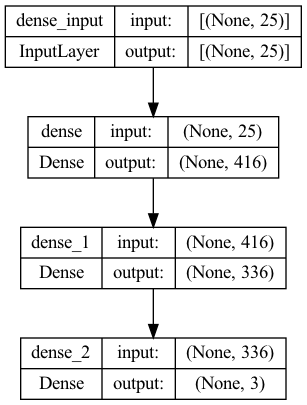

In [49]:
tf.keras.utils.plot_model(best_model_3, to_file='../plots/model_plots/ann_model_3.png', show_shapes=True)

In [50]:
y_pred = best_model_3.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

118/338 [=========>....................] - ETA: 0s

2023-01-13 11:30:23.856520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 0s 1ms/step


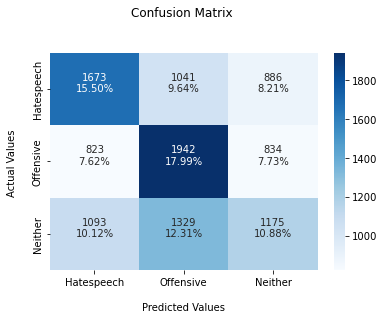

In [51]:
plotConfusionMatrix(cm)

In [52]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.47      0.46      0.47      3600
           1       0.45      0.54      0.49      3599
           2       0.41      0.33      0.36      3597

    accuracy                           0.44     10796
   macro avg       0.44      0.44      0.44     10796
weighted avg       0.44      0.44      0.44     10796



In [53]:
best_model_3.save('../models/ann_models/ann_model_3')

INFO:tensorflow:Assets written to: ../models/ann_models/ann_model_3/assets
